# Integrantes:

##### -Rodrigo Pino
##### -Cristobal Cortes
##### -Edgar Ramos
##### -Christian Garrido

# Acerca de la data

##### El conjunto de datos consiste en imágenes de rayos X de radiografías de tórax recopiladas de pacientes pediátricos de uno a cinco años del Guangzhou Women and Children's Medical Center en Guangzhou. Se seleccionaron un total de 5.863 imágenes, las cuales se distribuyen en tres conjuntos: entrenamiento (train), prueba (test) y validación (val).

##### Antes de utilizar las imágenes para el entrenamiento de un modelo de red neuronal convolucional, se aplicó un proceso de control de calidad para eliminar aquellas de baja calidad o ilegibles. Dos médicos expertos revisaron y clasificaron los diagnósticos de las imágenes, asegurando la precisión de la información proporcionada. Además, un tercer experto llevó a cabo una revisión adicional del conjunto de evaluación para garantizar su calidad.

##### En resumen, este conjunto de datos comprende imágenes de rayos X de tórax de pacientes pediátricos, previamente revisadas y clasificadas por expertos médicos. Estas imágenes se utilizán para el desarrollo y la evaluación de modelos de inteligencia artificial, y se dividen en conjuntos de entrenamiento, prueba y validación.

# Reconocimientos

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

# __________________________________________________________________________________________________________________________________________

# Importar la data

##### Debido a la enorme cantidad de datos que conformaban nuestro conjunto, en forma de imágenes, nos enfrentamos a un desafío significativo. Estas imágenes requerían una cantidad considerable de recursos, particularmente memoria RAM, lo cual dificultaba el adecuado preprocesamiento y entrenamiento de los datos. Para superar esta problemática, recurrimos a una herramienta fundamental: la función image_dataset_from_directory() de la biblioteca Keras en TensorFlow. Utilizando esta herramienta, redimensionamos todas las imágenes a un tamaño de 128x128 píxeles y las convertimos a escala de grises. Además, establecimos un batch_size de 32 para gestionar el procesamiento en lotes de manera eficiente. Esta estrategia nos permitió manejar y aprovechar eficazmente los recursos disponibles, facilitando así el preprocesamiento y entrenamiento efectivo de nuestro conjunto de datos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

2023-05-31 23:17:19.256363: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 23:17:19.324623: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 23:17:19.325569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 23:17:20.841605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
train_dir = "./Chest_X-rays/train/"
valid_dir = "./Chest_X-rays/val/"
test_dir = "./Chest_X-rays/test/"

img_height = 224
img_width = 224
#batch_size = 32

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    color_mode='rgb',
    image_size=(img_height, img_width)
    #batch_size=batch_size
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    color_mode='rgb',
    image_size=(img_height, img_width)
    #batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    color_mode='rgb',
    image_size=(img_height, img_width)
    #batch_size=batch_size
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


2023-05-31 20:36:07.252167: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-05-31 20:36:07.252199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: cgarretes-Laptop
2023-05-31 20:36:07.252205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: cgarretes-Laptop
2023-05-31 20:36:07.252307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.105.17
2023-05-31 20:36:07.252329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17
2023-05-31 20:36:07.252335: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.105.17


# Visualizamos muestras los conjuntos de datos

2023-05-31 12:12:01.117108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5216]
	 [[{{node Placeholder/_0}}]]
2023-05-31 12:12:01.117819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]


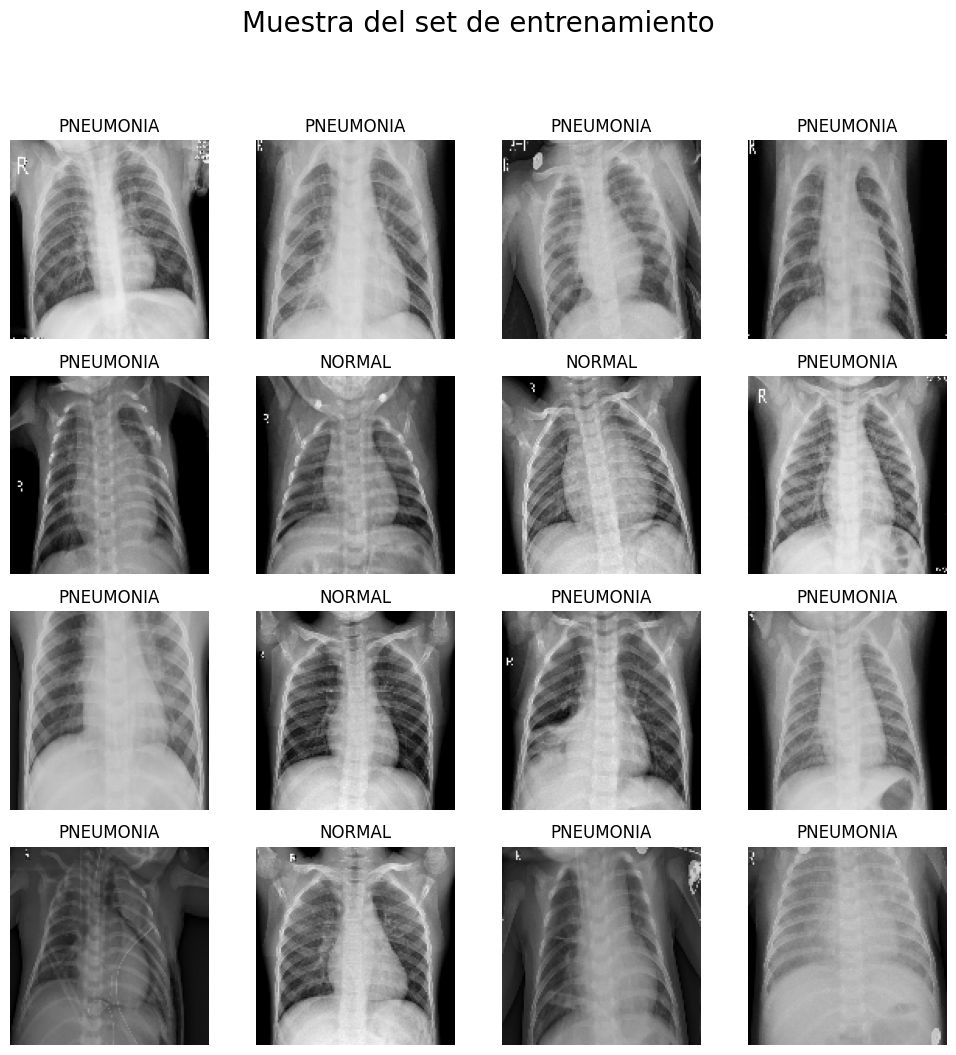

In [5]:
class_names = train_ds.class_names

# Iterar sobre el conjunto de datos y mostrar las imágenes
for images, labels in train_ds.take(1):  # Tomar solo un lote de imágenes
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for img, lbl, ax in zip(images, labels, axes):
        ax.imshow(img.numpy().astype("uint8"), cmap="gray")
        ax.set_title(class_names[lbl])
        ax.axis("off")

    fig.suptitle("Muestra del set de entrenamiento", fontsize=20, y=1.05)
    plt.tight_layout()
    plt.show()

2023-05-31 12:12:03.309932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16]
	 [[{{node Placeholder/_4}}]]
2023-05-31 12:12:03.310469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16]
	 [[{{node Placeholder/_0}}]]


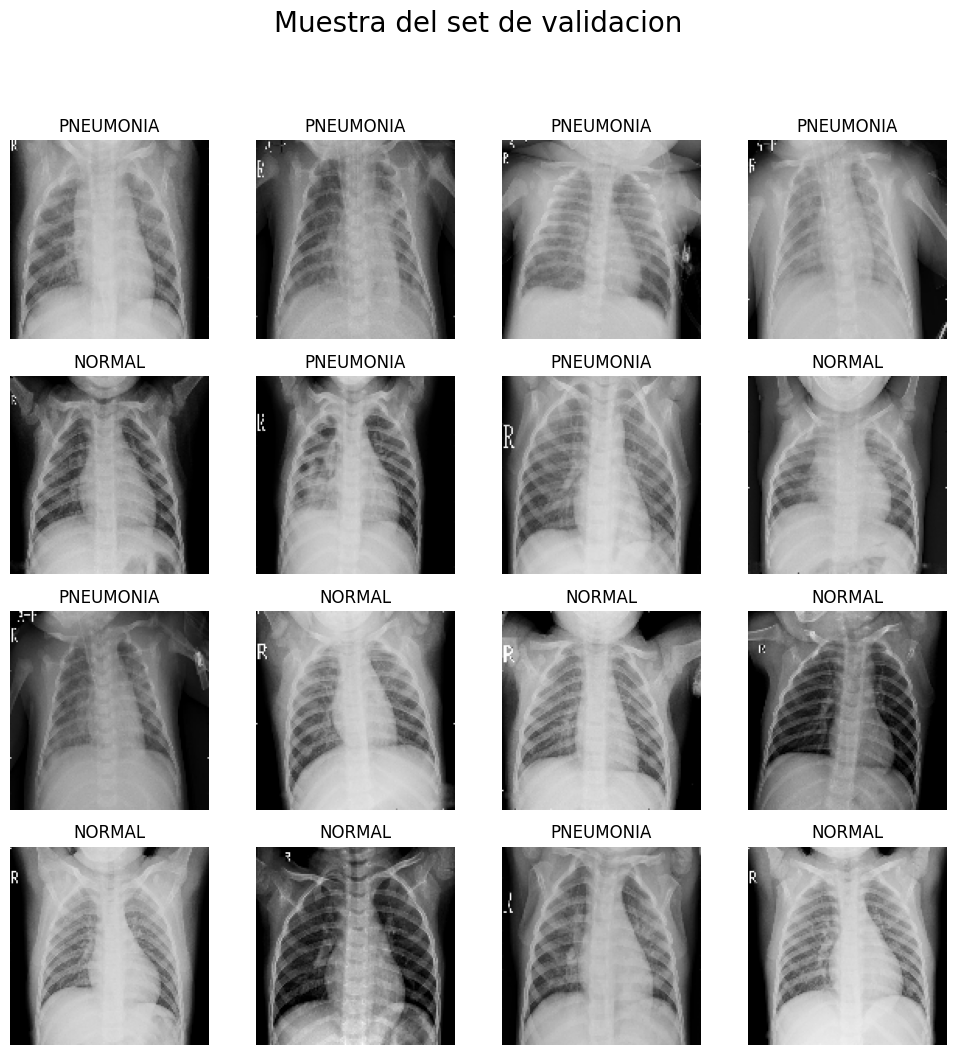

In [6]:
for images, labels in valid_ds.take(1):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for img, lbl, ax in zip(images, labels, axes):
        ax.imshow(img.numpy().astype("uint8"), cmap="gray")
        ax.set_title(class_names[lbl])
        ax.axis("off")

    fig.suptitle("Muestra del set de validacion", fontsize=20, y=1.05)
    plt.tight_layout()
    plt.show()

2023-05-31 12:12:05.362125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [624]
	 [[{{node Placeholder/_4}}]]
2023-05-31 12:12:05.364038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [624]
	 [[{{node Placeholder/_4}}]]


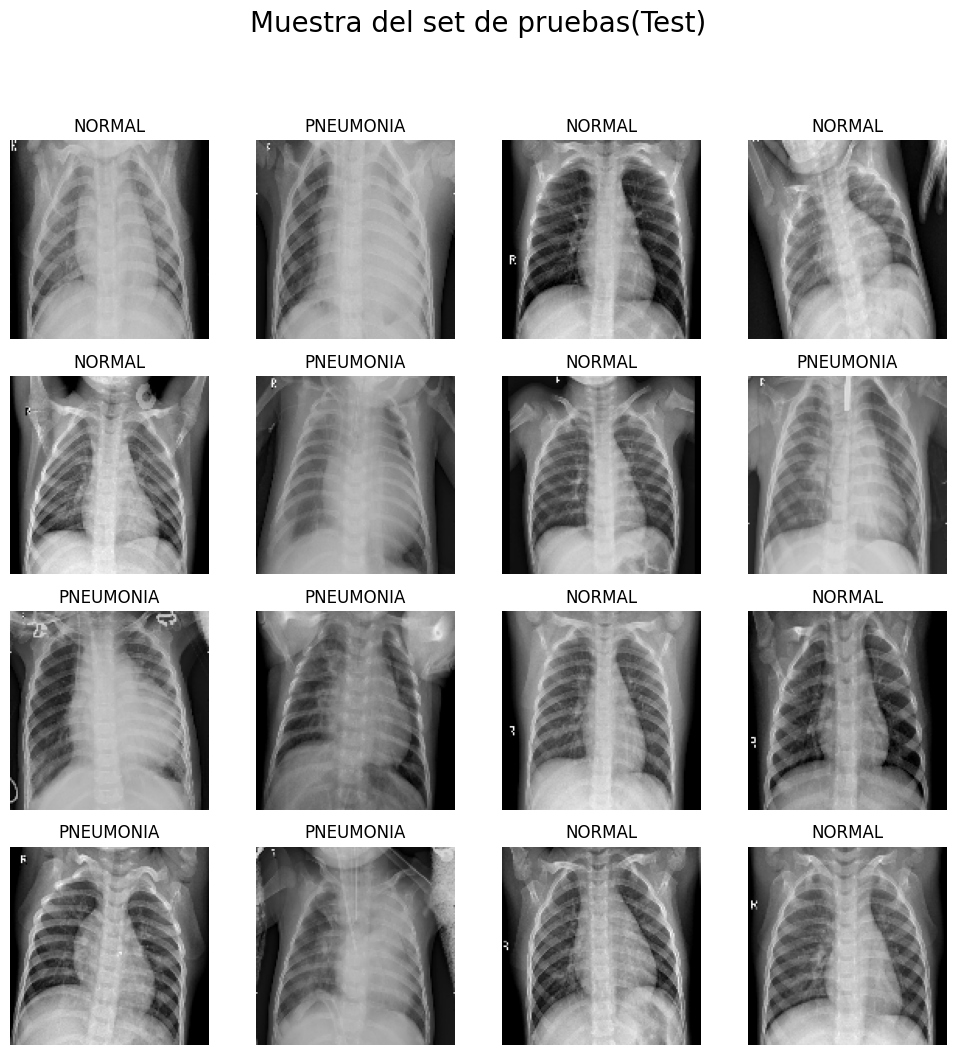

In [7]:
for images, labels in test_ds.take(1):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for img, lbl, ax in zip(images, labels, axes):
        ax.imshow(img.numpy().astype("uint8"), cmap="gray")
        ax.set_title(class_names[lbl])
        ax.axis("off")

    fig.suptitle("Muestra del set de pruebas(Test)", fontsize=20, y=1.05)
    plt.tight_layout()
    plt.show()

# __________________________________________________________________________________________________________________________________________

# Analizamos los datos

### Conjunto de entrenamiento

In [8]:
# Obtener las etiquetas de un conjunto de datos
labels = np.concatenate([labels for _, labels in train_ds], axis=0)

# Contar la cantidad de etiquetas con valor 0 y 1
class_counts = np.bincount(labels)

# Imprimir la cantidad de etiquetas para cada clase
print("Cantidad de etiquetas clase 0:", class_counts[0])
print("Cantidad de etiquetas clase 1:", class_counts[1])

2023-05-31 12:12:12.628432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]
2023-05-31 12:12:12.629050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]


Cantidad de etiquetas clase 0: 1341
Cantidad de etiquetas clase 1: 3875


### Conjunto de validacion

In [9]:
# Obtener las etiquetas de un conjunto de datos
labels = np.concatenate([labels for _, labels in valid_ds], axis=0)

# Contar la cantidad de etiquetas con valor 0 y 1
class_counts = np.bincount(labels)

# Imprimir la cantidad de etiquetas para cada clase
print("Cantidad de etiquetas clase 0:", class_counts[0])
print("Cantidad de etiquetas clase 1:", class_counts[1])

Cantidad de etiquetas clase 0: 8
Cantidad de etiquetas clase 1: 8


2023-05-31 12:12:32.009973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16]
	 [[{{node Placeholder/_0}}]]
2023-05-31 12:12:32.010438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16]
	 [[{{node Placeholder/_0}}]]


### Conjunto de Prueba

In [10]:
# Obtener las etiquetas de un conjunto de datos
labels = np.concatenate([labels for _, labels in test_ds], axis=0)

# Contar la cantidad de etiquetas con valor 0 y 1
class_counts = np.bincount(labels)

# Imprimir la cantidad de etiquetas para cada clase
print("Cantidad de etiquetas clase 0:", class_counts[0])
print("Cantidad de etiquetas clase 1:", class_counts[1])

2023-05-31 12:12:33.290604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [624]
	 [[{{node Placeholder/_0}}]]
2023-05-31 12:12:33.291063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [624]
	 [[{{node Placeholder/_4}}]]


Cantidad de etiquetas clase 0: 234
Cantidad de etiquetas clase 1: 390


### Conjunto de entrenamiento:

- Cantidad de etiquetas de clase 0 (Normal): 1341
- Cantidad de etiquetas de clase 1 (Pneumonia): 3875

### Conjunto de validación:

- Cantidad de etiquetas de clase 0 (Normal): 8
- Cantidad de etiquetas de clase 1 (Pneumonia): 8

### Conjunto de prueba:

- Cantidad de etiquetas de clase 0 (Normal): 234
- Cantidad de etiquetas de clase 1 (Pneumonia): 390

Este análisis muestra la distribución de las etiquetas de clase en cada conjunto de datos. En el conjunto de entrenamiento, hay 1341 imágenes etiquetadas como "Normal" y 3875 imágenes etiquetadas como "Pneumonia". En el conjunto de validación y prueba, las cantidades son mucho menores, con 8 imágenes de cada clase en el conjunto de validación y 234 imágenes "Normales" y 390 imágenes "Pneumonia" en el conjunto de prueba.

# __________________________________________________________________________________________________________________________________________

# Transfer Learning

### ResNet50 como base para los primeros modelos

In [11]:
base_model_resnet = tf.keras.applications.ResNet50(include_top=False,
                                                    weights="imagenet",
                                                    input_shape=(128, 128, 3),
                                                    pooling='max',
                                                    classes=2)
base_model_resnet.summary()

### VGG16 como base para los segundos modelos

In [7]:
base_model_vgg = tf.keras.applications.VGG16(include_top=False,
                                             weights="imagenet",
                                             input_shape=(128,128,3),
                                             pooling="max",
                                             classes=2)
base_model_vgg.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

### No se modificaran los pesos y bias del modelo base, por lo que se debera bloquear los parametros entrenables

# Creamos los modelos

In [17]:
# base_model_resnet.trainable = False
# base_model_vgg.trainable = False

# denselayer1 = tf.keras.layers.Dense(100, activation='relu');
# denselayer2 = tf.keras.layers.Dense(50, activation='relu');
# denselayer3 = tf.keras.layers.Dense(10, activation='relu');
# output_layer = tf.keras.layers.Dense(1, activation='sigmoid');

# modelo_1_resnet = tf.keras.models.Sequential([
#     base_model_resnet,
#     tf.keras.layers.Flatten,
#     denselayer1,
#     output_layer
# ])


# modelo_1_resnet.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 23,792,713
Trainable params: 205,001
Non-trainable params: 23,587,712
_________________________________________________________________


### Compilamos el modelo

In [18]:
# optimizador = tf.keras.optimizers.Adam(learning_rate=0.001)

In [19]:
# modelo_1.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=["Accuracy"])

### Entrenamos los modelos

In [20]:
# tb = TensorBoard(log_dir="./logs/modelo_1_cpu")

In [21]:
modelo_1.fit(train_ds, epochs=100, validation_data=(valid_ds), callbacks=[tb])

Epoch 1/100
163/163 [==============================] - 115s 681ms/step - loss: 0.2753 - Accuracy: 0.9314 - val_loss: 1.1476 - val_Accuracy: 0.6875
Epoch 2/100
163/163 [==============================] - 95s 578ms/step - loss: 0.0993 - Accuracy: 0.9674 - val_loss: 1.5458 - val_Accuracy: 0.6875
Epoch 3/100
163/163 [==============================] - 93s 568ms/step - loss: 0.0619 - Accuracy: 0.9770 - val_loss: 0.3307 - val_Accuracy: 0.8750
Epoch 4/100
163/163 [==============================] - 102s 626ms/step - loss: 0.0368 - Accuracy: 0.9870 - val_loss: 0.2035 - val_Accuracy: 0.8750
Epoch 5/100
163/163 [==============================] - 114s 693ms/step - loss: 0.0365 - Accuracy: 0.9862 - val_loss: 0.7727 - val_Accuracy: 0.7500
Epoch 6/100
163/163 [==============================] - 100s 612ms/step - loss: 0.0291 - Accuracy: 0.9896 - val_loss: 1.9703 - val_Accuracy: 0.5625
Epoch 7/100
163/163 [==============================] - 98s 598ms/step - loss: 0.0315 - Accuracy: 0.9870 - val_loss: 1.08

In [22]:
directorio_modelos = './trained_models/modelo_1_cpu/'
nombre_del_modelo = 'modelo1_1l_100n'
modelo_1.save(f'{directorio_modelos}/{nombre_del_modelo}')

INFO:tensorflow:Assets written to: ./trained_models/modelo_1//modelo1_1l_100n/assets


INFO:tensorflow:Assets written to: ./trained_models/modelo_1//modelo1_1l_100n/assets


### Mismo modelo entrenado con gpu.

### Los archivos serán cargados en el directorio para despues visualizarlos con tensorboard e importar el modelo

# Cargamos el modelo

In [8]:
modelo_1_gpu = tf.keras.models.load_model("./trained_models/modelo1_gpu/")

In [18]:
modelo_1_cpu= tf.keras.models.load_model("./trained_models/modelo_1_cpu/")

In [9]:
# Exportar modelo a js

modelo_1_gpu.save('prototipo.h5')

In [2]:
!tensorboard --logdir=./logs

2023-05-31 23:17:39.639387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-31 23:17:40.563213: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [40]:
directorio_modelos = './trained_models/modelos_sigmoide/modelo_sigmoide_no_padding'
nombre_del_modelo = 'modelo_sigmoide_sin_padding'
modelo_sigmoid_sin_padding.save(f'{directorio_modelos}/{nombre_del_modelo}')

INFO:tensorflow:Assets written to: ./trained_models/modelos_sigmoide/modelo_sigmoide_no_padding/modelo_sigmoide_sin_padding/assets


INFO:tensorflow:Assets written to: ./trained_models/modelos_sigmoide/modelo_sigmoide_no_padding/modelo_sigmoide_sin_padding/assets


In [ ]:
!tensorboard --logdir=./logs

In [36]:
tb = TensorBoard(log_dir="./logs/modelo_sigmoide_con_padding")

In [37]:
modelo_sigmoid_padding.fit(trainX_padded, trainY, epochs=100, validation_data=(validX_padded, validY), callbacks=[tb])

Epoch 1/100
148/148 [==============================] - 20s 104ms/step - loss: 0.2534 - Accuracy: 0.8934 - val_loss: 2.0402 - val_Accuracy: 0.7424
Epoch 2/100
148/148 [==============================] - 11s 72ms/step - loss: 0.2431 - Accuracy: 0.8976 - val_loss: 1.9450 - val_Accuracy: 0.7424
Epoch 3/100
148/148 [==============================] - 11s 74ms/step - loss: 0.2276 - Accuracy: 0.9087 - val_loss: 1.9293 - val_Accuracy: 0.7424
Epoch 4/100
148/148 [==============================] - 14s 97ms/step - loss: 0.2187 - Accuracy: 0.9112 - val_loss: 1.9786 - val_Accuracy: 0.7424
Epoch 5/100
148/148 [==============================] - 20s 134ms/step - loss: 0.2146 - Accuracy: 0.9136 - val_loss: 1.9716 - val_Accuracy: 0.7424
Epoch 6/100
148/148 [==============================] - 12s 81ms/step - loss: 0.2045 - Accuracy: 0.9125 - val_loss: 1.8228 - val_Accuracy: 0.7424
Epoch 7/100
148/148 [==============================] - 10s 71ms/step - loss: 0.1987 - Accuracy: 0.9189 - val_loss: 2.1327 - val_

In [41]:
directorio_modelos = './trained_models/modelos_sigmoide/modelo_sigmoide_padding/'
nombre_del_modelo = 'modelo_sigmoide_con_padding'
modelo_sigmoid_padding.save(f'{directorio_modelos}/{nombre_del_modelo}')

INFO:tensorflow:Assets written to: ./trained_models/modelos_sigmoide/modelo_sigmoide_padding//modelo_sigmoide_con_padding/assets


INFO:tensorflow:Assets written to: ./trained_models/modelos_sigmoide/modelo_sigmoide_padding//modelo_sigmoide_con_padding/assets


### Modelos Softmax

In [43]:
base_model = tensorflow.keras.applications.ResNet50(include_top=False,
                                                    weights="imagenet",
                                                    input_shape=(32, 32, 3),
                                                    pooling='max',
                                                    classes=2)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

tensorflow.keras.layers.Flatten = tensorflow.keras.layers.Flatten;
denselayer1 = tensorflow.keras.layers.Dense(100, activation='relu');
output_layer = tensorflow.keras.layers.Dense(2, activation='softmax');

modelo_softmax_sin_padding = tensorflow.keras.models.Sequential([
    base_model,
    tensorflow.keras.layers.Flatten,
    denselayer1,
    output_layer
])
modelo_softmax_padding = tensorflow.keras.models.Sequential([
    base_model,
    tensorflow.keras.layers.Flatten,
    denselayer1,
    output_layer
])

### Compilamos los modelos

In [51]:
optimizador = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

In [52]:
modelo_softmax_padding.compile(loss="categorical_crossentropy", optimizer=optimizador, metrics=["Accuracy"])
modelo_softmax_sin_padding.compile(loss="categorical_crossentropy", optimizer=optimizador, metrics=["Accuracy"])

### Entrenamos los modelos

In [53]:
tb = TensorBoard(log_dir="./logs/modelo_softmax_sin_padding")

In [54]:
modelo_softmax_sin_padding.fit(trainX_no_padding, trainY_ohe, epochs=100, validation_data=(validX_no_padding, validY_ohe), callbacks=[tb])

Epoch 1/100
148/148 [==============================] - 14s 73ms/step - loss: 0.5291 - Accuracy: 0.7576 - val_loss: 0.3790 - val_Accuracy: 0.8340
Epoch 2/100
148/148 [==============================] - 8s 56ms/step - loss: 0.3639 - Accuracy: 0.8483 - val_loss: 0.3366 - val_Accuracy: 0.8893
Epoch 3/100
148/148 [==============================] - 9s 58ms/step - loss: 0.3253 - Accuracy: 0.8645 - val_loss: 0.2686 - val_Accuracy: 0.8836
Epoch 4/100
148/148 [==============================] - 12s 83ms/step - loss: 0.2793 - Accuracy: 0.8859 - val_loss: 0.5573 - val_Accuracy: 0.7252
Epoch 5/100
148/148 [==============================] - 9s 59ms/step - loss: 0.2580 - Accuracy: 0.8942 - val_loss: 0.3447 - val_Accuracy: 0.8397
Epoch 6/100
148/148 [==============================] - 9s 62ms/step - loss: 0.2737 - Accuracy: 0.8862 - val_loss: 0.5831 - val_Accuracy: 0.7099
Epoch 7/100
148/148 [==============================] - 9s 61ms/step - loss: 0.2400 - Accuracy: 0.9021 - val_loss: 0.2776 - val_Accurac

In [55]:
directorio_modelos = './trained_models/modelos_softmax/modelo_softmax_no_padding'
nombre_del_modelo = 'modelo_softmax_sin_padding'
modelo_softmax_sin_padding.save(f'{directorio_modelos}/{nombre_del_modelo}')

INFO:tensorflow:Assets written to: ./trained_models/modelos_softmax/modelo_softmax_no_padding/modelo_softmax_sin_padding/assets


INFO:tensorflow:Assets written to: ./trained_models/modelos_softmax/modelo_softmax_no_padding/modelo_softmax_sin_padding/assets


In [56]:
tb = TensorBoard(log_dir="./logs/modelo_softmax_con_padding")

# Entrenar el modelo

In [57]:
modelo_softmax_padding.fit(trainX_padded, trainY_ohe, epochs=100, validation_data=(validX_padded, validY_ohe), callbacks=[tb])

Epoch 1/100
148/148 [==============================] - 18s 96ms/step - loss: 0.2414 - Accuracy: 0.9004 - val_loss: 2.1891 - val_Accuracy: 0.7424
Epoch 2/100
148/148 [==============================] - 10s 66ms/step - loss: 0.2378 - Accuracy: 0.9002 - val_loss: 1.9735 - val_Accuracy: 0.7424
Epoch 3/100
148/148 [==============================] - 8s 57ms/step - loss: 0.2334 - Accuracy: 0.9023 - val_loss: 2.2086 - val_Accuracy: 0.7424
Epoch 4/100
148/148 [==============================] - 9s 61ms/step - loss: 0.2100 - Accuracy: 0.9129 - val_loss: 2.5464 - val_Accuracy: 0.7424
Epoch 5/100
148/148 [==============================] - 9s 59ms/step - loss: 0.2264 - Accuracy: 0.9031 - val_loss: 2.5640 - val_Accuracy: 0.7424
Epoch 6/100
148/148 [==============================] - 8s 52ms/step - loss: 0.2086 - Accuracy: 0.9108 - val_loss: 2.4404 - val_Accuracy: 0.7424
Epoch 7/100
148/148 [==============================] - 10s 66ms/step - loss: 0.2122 - Accuracy: 0.9114 - val_loss: 2.3450 - val_Accura

# Guardamos los modelos

In [58]:
directorio_modelos = './trained_models/modelos_softmax/modelo_softmax_padding/'
nombre_del_modelo = 'modelo_softmax_con_padding'
modelo_softmax_padding.save(f'{directorio_modelos}/{nombre_del_modelo}')

INFO:tensorflow:Assets written to: ./trained_models/modelos_softmax/modelo_softmax_padding//modelo_softmax_con_padding/assets


INFO:tensorflow:Assets written to: ./trained_models/modelos_softmax/modelo_softmax_padding//modelo_softmax_con_padding/assets


In [1]:
!tensorboard --logdir=./logs

2023-05-31 19:15:34.030417: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 19:15:34.071926: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 19:15:34.072260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 19:15:35.115444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-31 19:15:36.182495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-05-31 19:15:36.182526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information f

### Cargar modelos

In [ ]:
modelo_sigmoid_padding = tensorflow.keras.models.load_model('trained_models/modelos_sigmoide/modelo_sigmoide_padding/')
modelo_sigmoid_sin_padding = tensorflow.keras.models.load_model('trained_models/modelos_sigmoide/modelo_sigmoide_no_padding/')
modelo_softmax_padding = tensorflow.keras.models.load_model('trained_models/modelos_softmax/modelo_softmax_padding/')
modelo_softmax_sin_padding = tensorflow.keras.models.load_model('trained_models/modelos_softmax/modelo_softmax_no_padding/')

### Matrices de confusion

In [79]:
# Obtener las etiquetas verdaderas y las predicciones de cada modelo

#Sigmoide

predicciones_modelo1 = modelo_sigmoid_sin_padding.predict([validX_no_padding]) # Predicciones del modelo sigmoide sin padding
predicciones_modelo2 = modelo_sigmoid_padding.predict([validX_padded]) # Predicciones del modelo sigmoide con padding

#Softmax

predicciones_modelo3 = modelo_softmax_sin_padding.predict([validX_no_padding])# Predicciones del modelo softmax sin padding
predicciones_modelo4 = modelo_softmax_padding.predict([validX_padded])# Predicciones del modelo softmax con padding

17/17 [==============================] - 1s 67ms/step


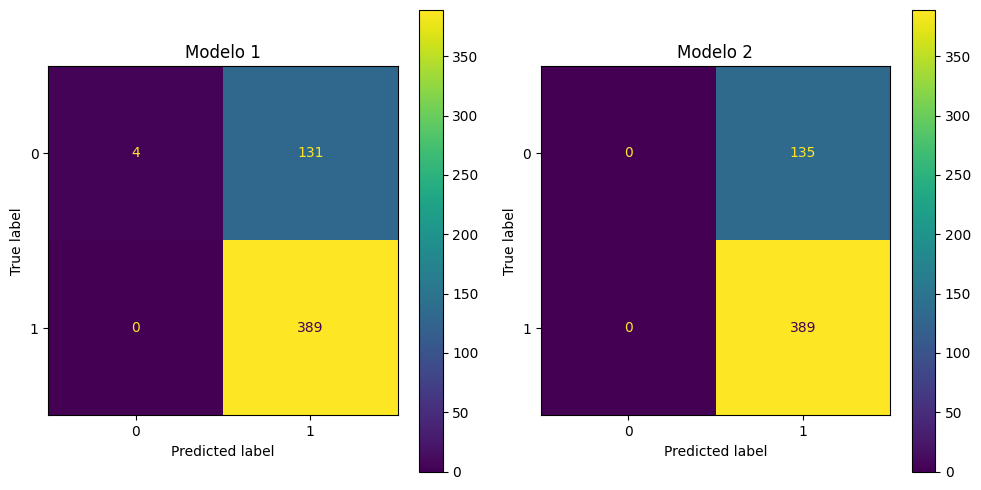

In [82]:
# Establecer el umbral para convertir las predicciones en valores binarios
umbral = 0.5
predicciones_modelo1_bin = (predicciones_modelo1 >= umbral).astype(int)
predicciones_modelo2_bin = (predicciones_modelo2 >= umbral).astype(int)

# Obtener las matrices de confusión de los dos modelos
cm_model1 = confusion_matrix(validY, predicciones_modelo1_bin)
cm_model2 = confusion_matrix(validY, predicciones_modelo2_bin)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Graficar la matriz de confusión del modelo 1
cm_display1 = ConfusionMatrixDisplay(cm_model1).plot(ax=axes[0])
axes[0].set_title('Modelo 1')

# Graficar la matriz de confusión del modelo 2
cm_display2 = ConfusionMatrixDisplay(cm_model2).plot(ax=axes[1])
axes[1].set_title('Modelo 2')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

* $C_0,_0$ -> verdaderos negativos (TN) = 4
* $C_1,_0$ -> falsos negativos (FN) = 0
* $C_1,_1$ -> verdaderos positivos (TP) = 389
* $C_0,_1$ -> falsos positivos (FP) = 131

Modelo 1:

* Verdaderos positivos (TP): 4
* Verdaderos negativos (TN): 131
* Falsos positivos (FP): 0
* Falsos negativos (FN): 389

En el modelo 1, observamos que hay una alta cantidad de falsos negativos (389), lo que indica que el modelo está teniendo dificultades para clasificar correctamente las muestras positivas. Sin embargo, no se han clasificado incorrectamente muestras negativas, ya que no hay falsos positivos en la matriz.

Modelo 2:

* Verdaderos positivos (TP): 0
* Verdaderos negativos (TN): 135
* Falsos positivos (FP): 0
* Falsos negativos (FN): 389

En el modelo 2, también encontramos una alta cantidad de falsos negativos (389), lo que sugiere que este modelo también tiene dificultades para clasificar correctamente las muestras positivas. Al igual que en el modelo 1, no se han clasificado incorrectamente muestras negativas.

En general, ambos modelos muestran dificultades para clasificar correctamente las muestras positivas, lo que se refleja en los altos valores de falsos negativos. Es importante considerar otras métricas de evaluación y explorar posibles mejoras en los modelos, como ajustar hiperparámetros, agregar capas adicionales o aumentar el tamaño del conjunto de datos, para mejorar el rendimiento y reducir los errores de clasificación.